<center><img src="https://user-images.githubusercontent.com/17668390/164736543-0ef58c66-dfb0-47c5-8e6e-26774dbc6fd3.gif" alt="Paris" class="center"></center>

---

[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib is a deep learning library that aims to collect state-of-the-art anomaly detection algorithms for benchmarking on both public and private datasets. Anomalib provides several ready-to-use implementations of anomaly detection algorithms described in the recent literature, as well as a set of tools that facilitate the development and implementation of custom models. The library has a strong focus on image-based anomaly detection, where the goal of the algorithm is to identify anomalous images, or anomalous pixel regions within images in a dataset.

It supports [`MVTec AD`](https://www.mvtec.com/company/research/datasets/mvtec-ad) (CC BY-NC-SA 4.0) and [`BeanTech`](https://paperswithcode.com/dataset/btad) (CC-BY-SA) for **benchmarking** and `folder` for custom dataset **training/inference**. In this notebook, we will explore `anomalib` with `MVTec AD` dataset. 

## Benchmarking Dataset: MVTec AD


**MVTec AD** is a dataset for benchmarking anomaly detection methods with a focus on industrial inspection. It contains over **5000** high-resolution images divided into **fifteen** different object and texture categories. Each category comprises a set of defect-free training images and a test set of images with various kinds of defects as well as images without defects. It's uploaded in kaggle platform, [HERE](https://www.kaggle.com/datasets/ipythonx/mvtec-ad). And now, we can use from kaggle environment. 


## Custom Dataset (With Mask)

For custom dataset, if you have **ground truth** mask, it would be easier to prepare the dataset according to **MVTech** format. Normally, we can find the data structure of **MVTec-AD** for [each object](https://www.kaggle.com/code/ipythonx/mvtec-ad-anomaly-detection-with-anomalib-library/data?scriptVersionId=93610841&select=bottle) as follows:

```yaml 
category (i.e. 'bottle')
  - ground_truth
    - defect_type_1
        file_name_mask.png
    - defect_type_2
        file_name_mask.png
      ...
  - test
    - defect_type_1
        file_name.png
    - defect_type_2
        file_name.png
      ...
    - good
        file_name.png
  train
    - good
        file_name.png
```

Note that, image file format is `.png` and in the file name of the ground truth mask, there is a postfix notation `_mask.`. 

# Installation 

In [ ]:
import os
DATA_DIR = 'D:\\ML Practice\\Industrial Anomaly\\Anomalib'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    !git clone https://github.com/openvinotoolkit/anomalib.git
    %cd anomalib
    !pip install -e . -q

Cloning into 'anomalib'...
remote: Enumerating objects: 17371, done.
remote: Counting objects: 100% (4179/4179), done.
remote: Compressing objects: 100% (1288/1288), done.
remote: Total 17371 (delta 2429), reused 3821 (delta 2213), pack-reused 13192
Receiving objects: 100% (17371/17371), 43.48 MiB | 23.57 MiB/s, done.
Resolving deltas: 100% (10026/10026), done.
/kaggle/working/anomalib
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, pprint, yaml, warnings, math, glob, cv2, random, logging

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')
logger = logging.getLogger("anomalib")

import anomalib
from pytorch_lightning import Trainer, seed_everything
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import configure_logger, get_experiment_logger

In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.device_count())      
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))        

1.11.0
11.0
8005
True
1
0
Tesla P100-PCIE-16GB


# Model Config Path

Currently, there are **10** anomaly detection models available in `anomalib` library. Namely, 

- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/development/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)
- [FastFlow](https://arxiv.org/abs/2111.07677)
- [DREAM](https://arxiv.org/pdf/2108.07610v2.pdf)
- [Reverse Distillation](https://arxiv.org/pdf/2201.10703v2.pdf)


Now, let's get their config paths from the respected folders.

In [ ]:
CONFIG_PATHS = 'D:\\ML Practice\\Industrial Anomaly\\Anomalib/models'
MODEL_CONFIG_PAIRS = {
    'patchcore': f'{CONFIG_PATHS}/patchcore/config.yaml',
    'padim':     f'{CONFIG_PATHS}/padim/config.yaml',
    'cflow':     f'{CONFIG_PATHS}/cflow/config.yaml',
    'dfkde':     f'{CONFIG_PATHS}/dfkde/config.yaml',
    'dfm':       f'{CONFIG_PATHS}/dfm/config.yaml',
    'ganomaly':  f'{CONFIG_PATHS}/ganomaly/config.yaml',
    'stfpm':     f'{CONFIG_PATHS}/stfpm/config.yaml',
    'fastflow':  f'{CONFIG_PATHS}/fastflow/config.yaml',
    'draem':     f'{CONFIG_PATHS}/draem/config.yaml',
    'reverse_distillation': f'{CONFIG_PATHS}/reverse_distillation/config.yaml',
}

## Quick Look

In this demonstration, we will choose `PATCHCORE` model from the above config; which is index 1 in the above dictionary. Let's take a quick look of its config file. 

In [5]:
MODEL = 'patchcore' # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
print(open(os.path.join(MODEL_CONFIG_PAIRS[MODEL]), 'r').read())

dataset:
  name: mvtec #options: [mvtec, btech, folder]
  format: mvtec
  path: ./datasets/MVTec
  task: segmentation
  category: bottle
  image_size: 224
  train_batch_size: 32
  test_batch_size: 1
  num_workers: 8
  transform_config:
    train: null
    val: null
  create_validation_set: false
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: patchcore
  backbone: wide_resnet50_2
  pre_trained: true
  layers:
    - layer2
    - layer3
  coreset_sampling_ratio: 0.1
  num_neighbors: 9
  normalization_method: min_max # options: [null, min_max, cdf]

metrics:
  image:
    - F1Score
    - AUROC
  pixel:
    - F1Score
    - AUROC
  threshold:
    image_default: 0
    pixel_default: 0
    adaptive: true

visualization:
  show_images: False # show images on the screen
  save_images: True # save images to the file system
  log_images: True # log images to the available loggers (if a

# Update Config 

In order to train on **MV-Tec** dataset, which is hosted on Kaggle, [HERE](https://www.kaggle.com/datasets/ipythonx/mvtec-ad), we may need to udpate some parameter in the configuration file, for example, `dataset.path`. Also, we may wish to tweak other parameters as well, i.e. `image_size`, `train_batch_size` etc.

In [ ]:
new_update = {
    "path": '"D:\\ML Practice\\Industrial Anomaly\\mvtec-ad"',
    'category': 'hazelnut', 
    'image_size': 256,
    'train_batch_size':48,
    'seed': 101
}

In the above dictionary, the keys (`path`, `category`, `image_size`, `train_batch_size`) are already exist in the model's config file. We just want to update their default values. In the following cell, we write a simple function that will do the job. Note that, in the config file, the `path` key is the nested key of both `dataset` and `project` key. We only need to update the value of `dataset.path` and not `project.path` for now. 

In [7]:
# update yaml key's value
def update_yaml(old_yaml, new_yaml, new_update):
    # load yaml
    with open(old_yaml) as f:
        old = yaml.safe_load(f)
                  
    temp = []
    def set_state(old, key, value):
        if isinstance(old, dict):
            for k, v in old.items():
                if k == 'project':
                    temp.append(k)
                if k == key:
                    if temp and k == 'path':
                        # right now, we don't wanna change `project.path`
                        continue
                    old[k] = value
                elif isinstance(v, dict):
                    set_state(v, key, value)
    
    # iterate over the new update key-value pari
    for key, value in new_update.items():
        set_state(old, key, value)
    
    # save the updated / modified yaml file
    with open(new_yaml, 'w') as f:
        yaml.safe_dump(old, f, default_flow_style=False)

In [8]:
# let's set a new path location of new config file 
new_yaml_path = CONFIG_PATHS + '/' + list(MODEL_CONFIG_PAIRS.keys())[0] + '_new.yaml'

# run the update yaml method to update desired key's values
update_yaml(MODEL_CONFIG_PAIRS[MODEL], new_yaml_path, new_update)

In [9]:
with open(new_yaml_path) as f:
    updated_config = yaml.safe_load(f)
pprint.pprint(updated_config) # check if it's updated

{'dataset': {'category': 'hazelnut',
             'create_validation_set': False,
             'format': 'mvtec',
             'image_size': 256,
             'name': 'mvtec',
             'num_workers': 8,
             'path': '/kaggle/input/mvtec-ad',
             'task': 'segmentation',
             'test_batch_size': 1,
             'tiling': {'apply': False,
                        'random_tile_count': 16,
                        'remove_border_count': 0,
                        'stride': None,
                        'tile_size': None,
                        'use_random_tiling': False},
             'train_batch_size': 48,
             'transform_config': {'train': None, 'val': None}},
 'logging': {'log_graph': False, 'logger': []},
 'metrics': {'image': ['F1Score', 'AUROC'],
             'pixel': ['F1Score', 'AUROC'],
             'threshold': {'adaptive': True,
                           'image_default': 0,
                           'pixel_default': 0}},
 'model': {'backbone'

# Prepare Model, Dataloader, Callbacks with `config`

Now, the config file is updated as we want. We can now start model training with it.

In [10]:
if updated_config['project']['seed'] != 0:
    print(updated_config['project']['seed'])
    seed_everything(updated_config['project']['seed'])

101


In [11]:
# It will return the configurable parameters in DictConfig object.
config = get_configurable_parameters(
    model_name=updated_config['model']['name'],
    config_path=new_yaml_path
)

In [12]:
# pass the config file to model, logger, callbacks and datamodule
model      = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks  = get_callbacks(config)
datamodule = get_datamodule(config)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [13]:
# start training
trainer = Trainer(**config.trainer, logger=experiment_logger, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [14]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(
    weights_path=trainer.checkpoint_callback.best_model_path
)
trainer.callbacks.insert(0, load_model_callback)
trainer.test(model=model, datamodule=datamodule)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │            1.0            │
│        pixel_AUROC        │    0.9879371523857117     │
│       pixel_F1Score       │    0.6205508708953857     │
└───────────────────────────┴───────────────────────────┘

[{'pixel_F1Score': 0.6205508708953857,
  'pixel_AUROC': 0.9879371523857117,
  'image_F1Score': 1.0,
  'image_AUROC': 1.0}]

# Visualization 

In [15]:
RESULT_PATH = os.path.join(
    updated_config['project']['path'],
    updated_config['model']['name'],
    updated_config['dataset']['format'], 
    updated_config['dataset']['category']
)
RESULT_PATH

'./results/patchcore/mvtec/hazelnut'

In [16]:
# a simple function to visualize the model's prediction (anomaly heatmap)
def vis(paths, n_images, is_random=True, figsize=(16, 16)):
    for i in range(n_images):
        image_name = paths[i]
        if is_random: image_name = random.choice(paths)
        img = cv2.imread(image_name)[:,:,::-1]
        
        category_type = image_name.split('/')[-4:-3:][0]
        defected_type = image_name.split('/')[-2:-1:][0]
        
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.title(
            f"Category : {category_type} and Defected Type : {defected_type}", 
            fontdict={'fontsize': 20, 'fontweight': 'medium'}
        )
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

In [17]:
for content in os.listdir(RESULT_PATH):
    if content == 'images':
        full_path = glob.glob(os.path.join(RESULT_PATH, content, '**',  '*.png'), recursive=True)
        print('Total Image ', len(full_path))
        print(full_path[0].split('/'))
        print(full_path[0].split('/')[-2:-1:])
        print(full_path[0].split('/')[-4:-3:])

Total Image  112
['.', 'results', 'patchcore', 'mvtec', 'hazelnut', 'images', 'image_ROC.png']
['images']
['mvtec']


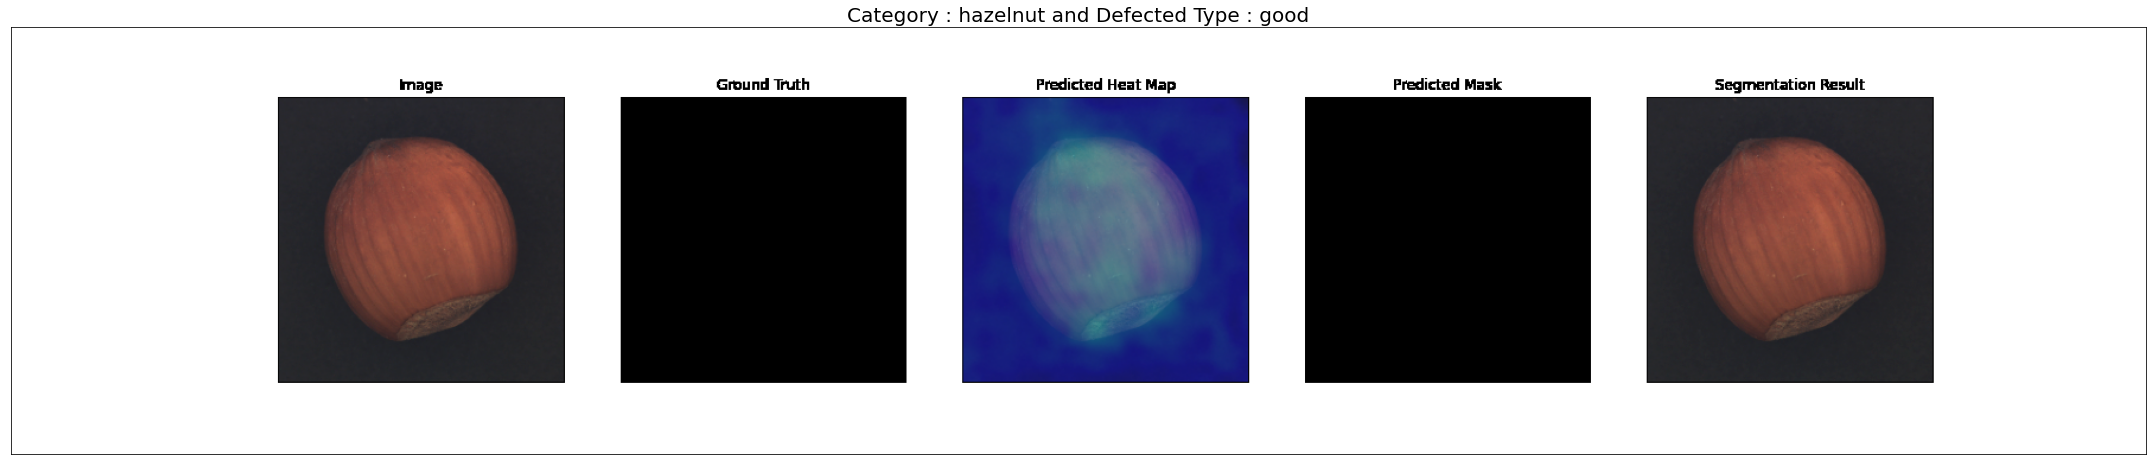

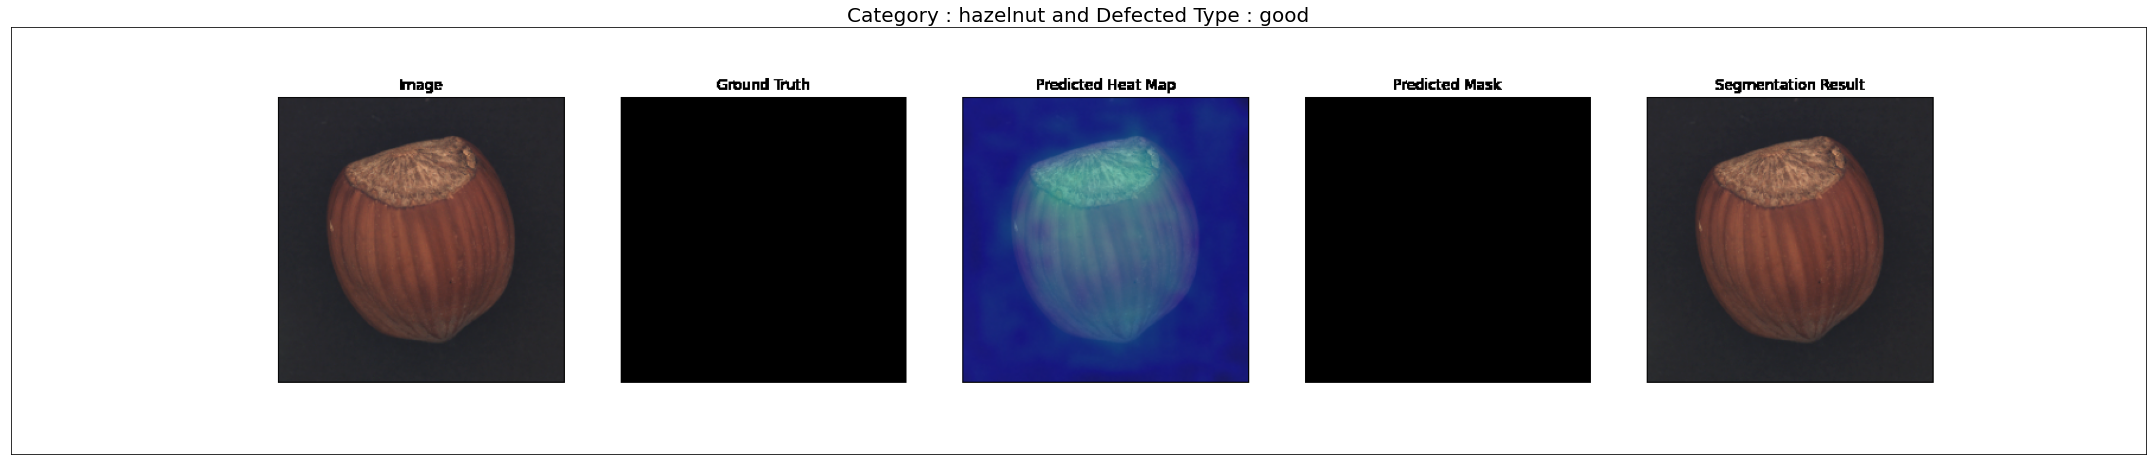

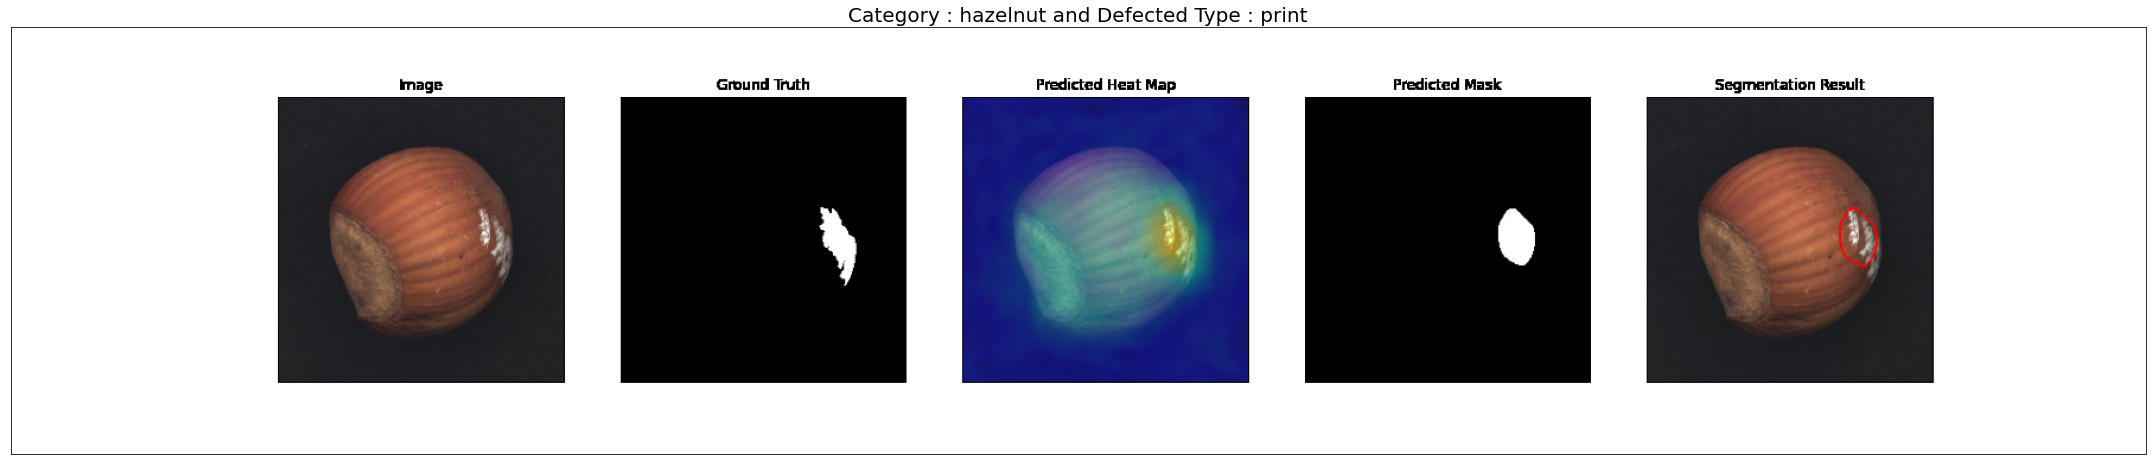

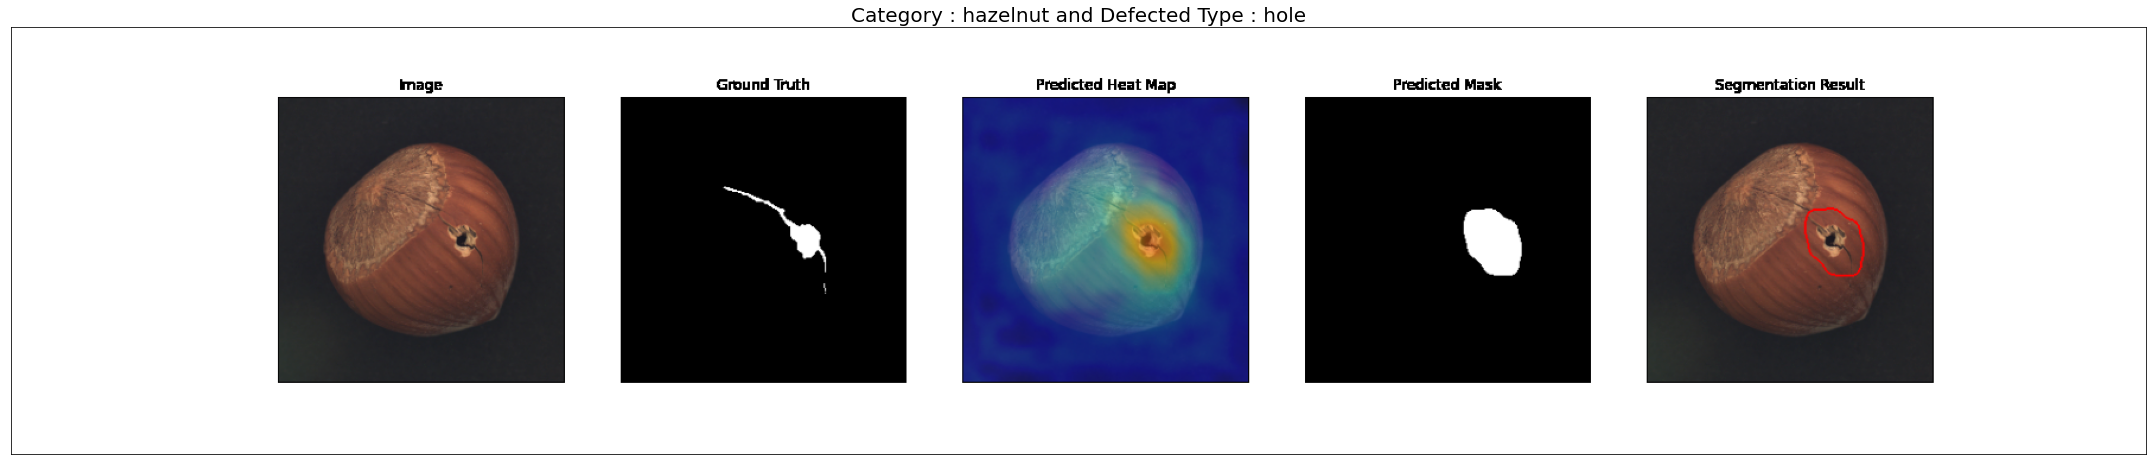

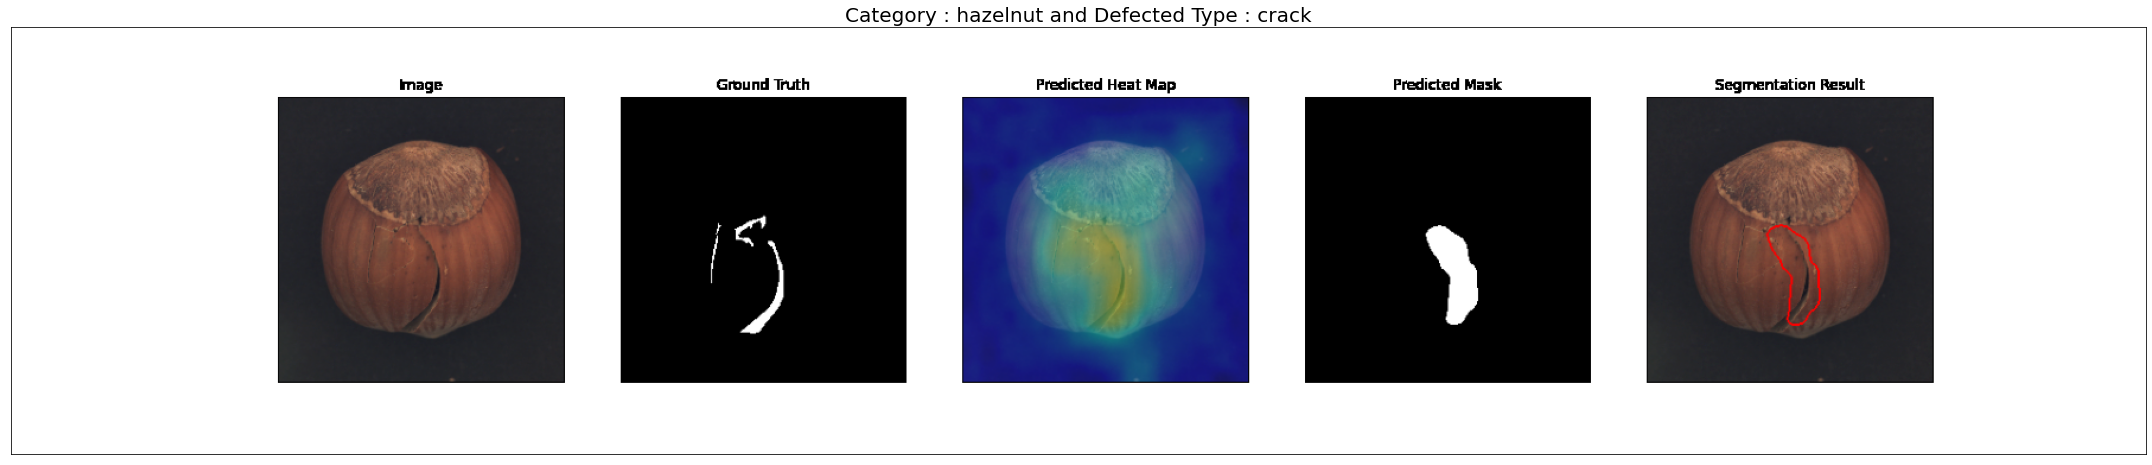

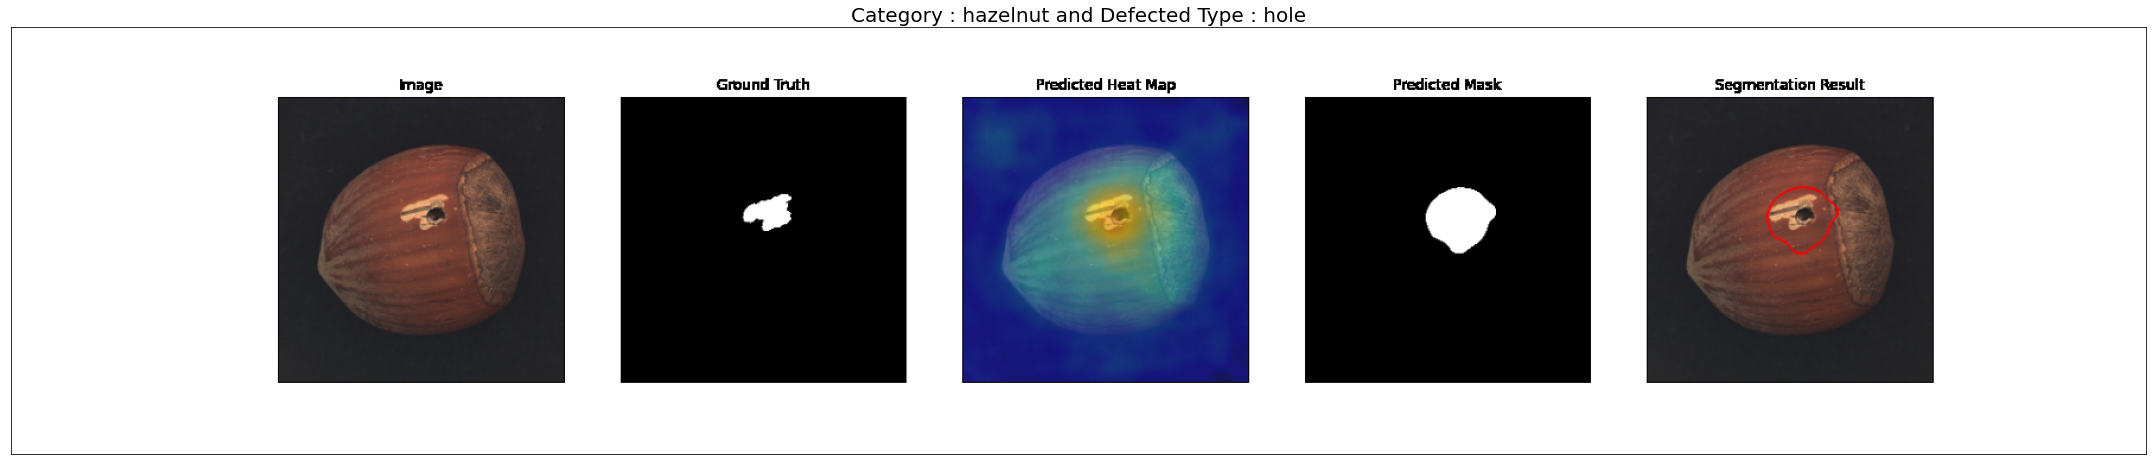

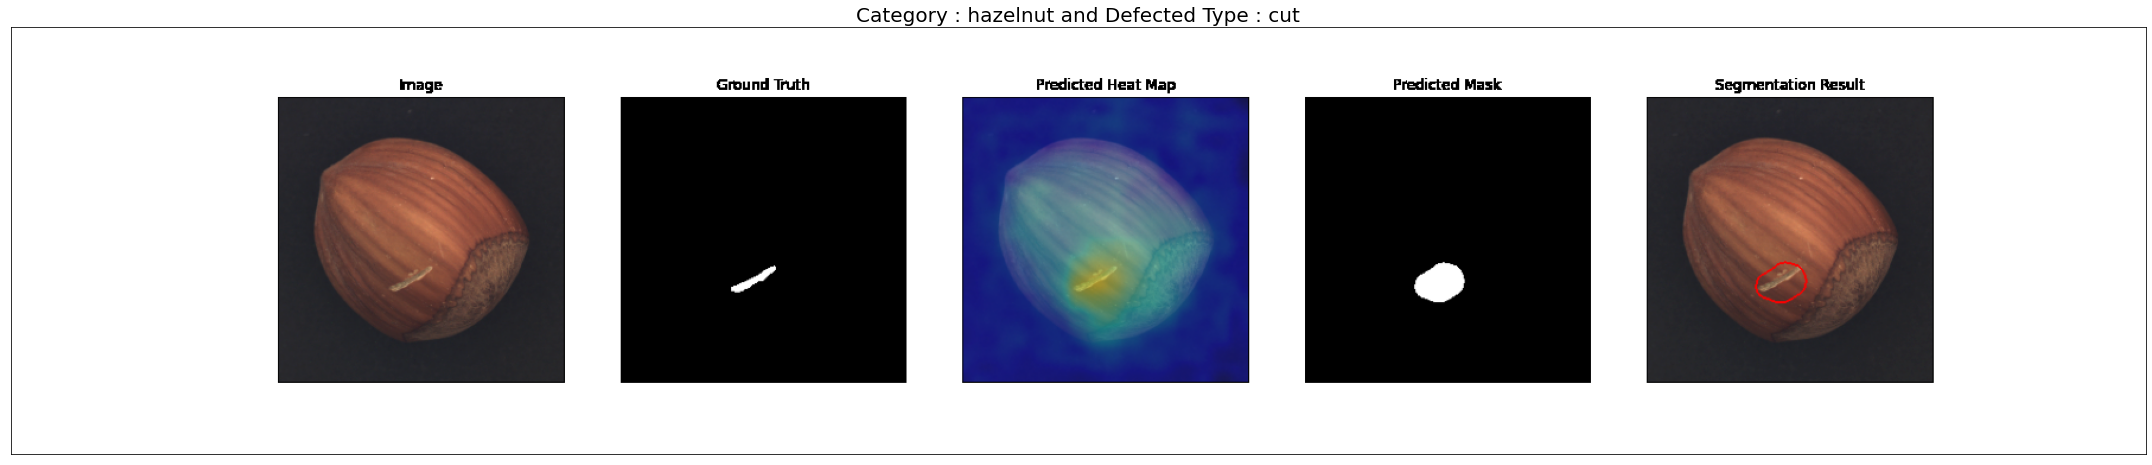

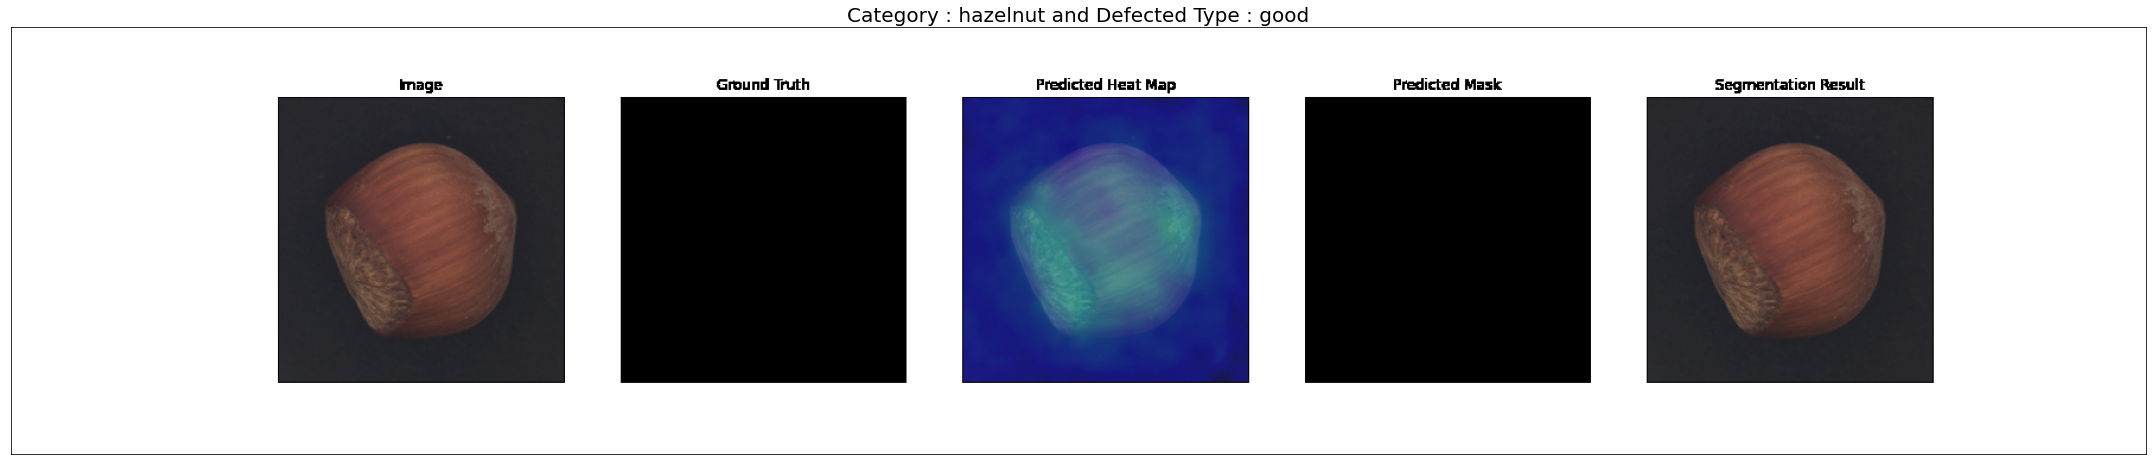

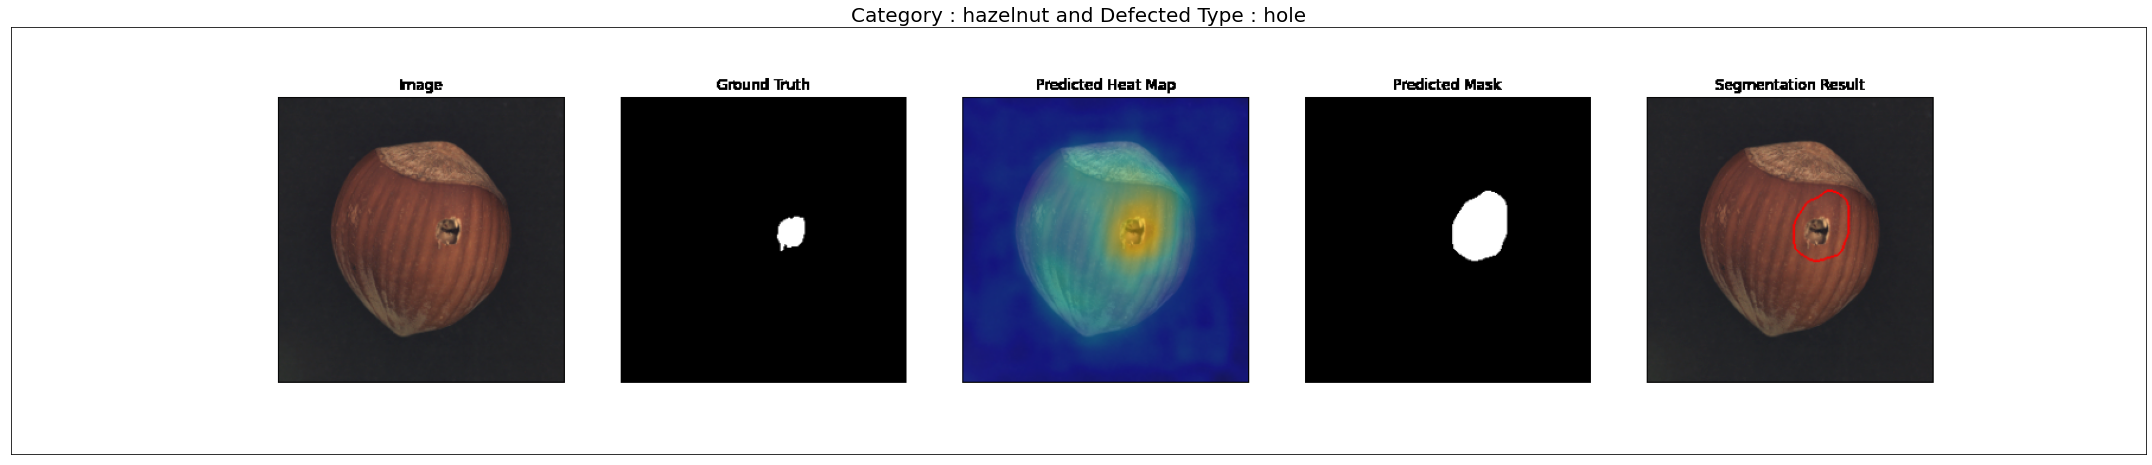

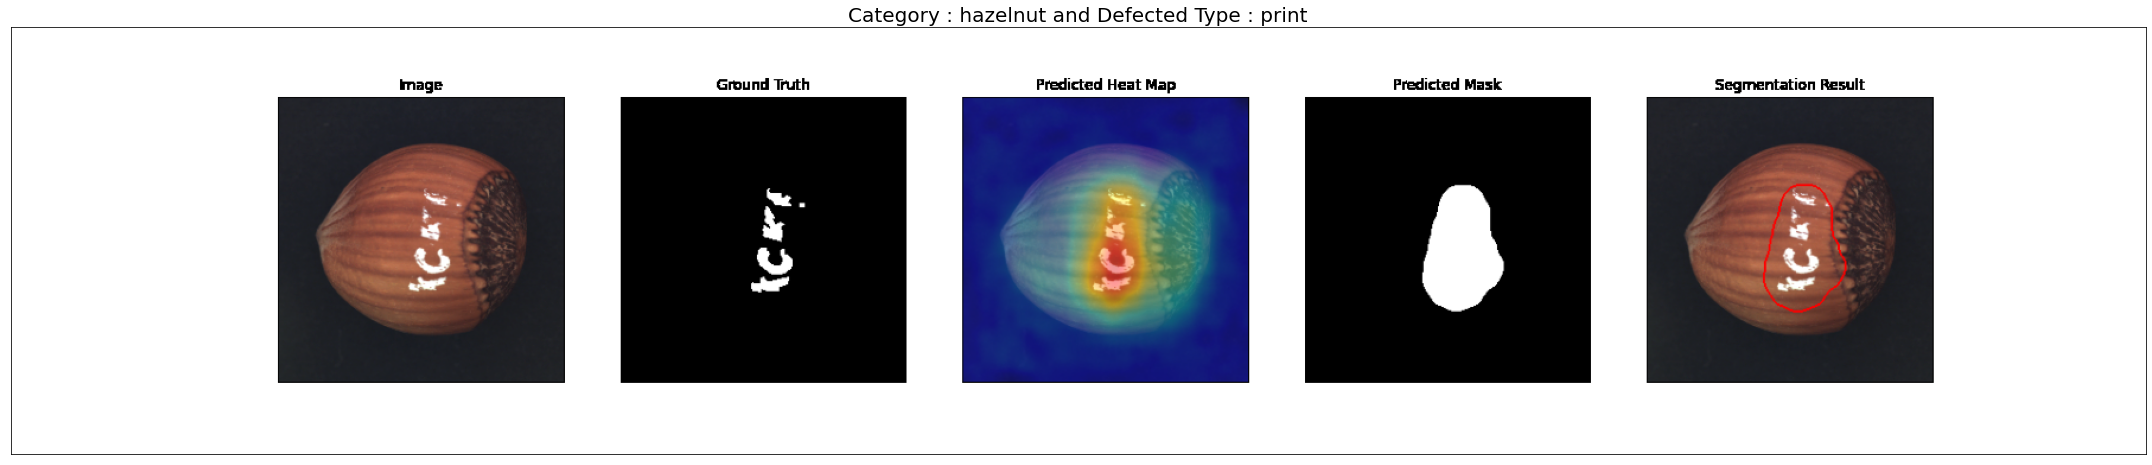

In [18]:
vis(full_path, 10, is_random=True, figsize=(30, 30))

# Inference

In [19]:
from torchvision.datasets.folder import IMG_EXTENSIONS

img_paths = sorted(
        [
            os.path.join(dirpath,filename) 
            for dirpath, _, filenames in os.walk(
                os.path.join(config.dataset.path, config.dataset.category, 'test')
            )
            for filename in filenames if filename.endswith(IMG_EXTENSIONS) 
            and not filename.startswith(".")
        ],
    )

img_paths = [img_path for img_path in img_paths if not "good" in img_path]
img_paths = random.sample(img_paths, 2)
img_paths

['/kaggle/input/mvtec-ad/hazelnut/test/cut/010.png',
 '/kaggle/input/mvtec-ad/hazelnut/test/hole/001.png']

In [ ]:
infer_resutls = "D:\\ML Practice\\Industrial Anomaly\\mvtec-ad\\infer_results\\"
os.makedirs(infer_resutls, exist_ok=True)

In [21]:
for infer_img_path in img_paths:
    !python tools/inference/torch_inference.py  \
        --config anomalib/models/{updated_config['model']['name']}/config.yaml \
        --weights {trainer.checkpoint_callback.best_model_path} \
        --input {infer_img_path} \
        --output ./infer_results \
        --task "segmentation" \
        --visualization_mode "full"

/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (AdaptiveThreshold). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictio

In [22]:
print(os.listdir(infer_resutls))

['cut', 'hole']


/kaggle/working/anomalib/infer_results/cut


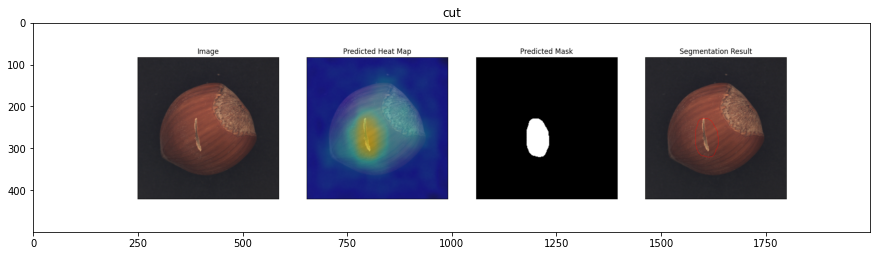

/kaggle/working/anomalib/infer_results/hole


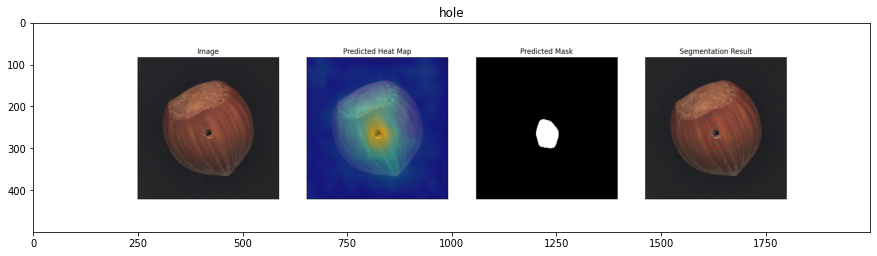

In [25]:
for folder_category in os.listdir(infer_resutls):
    folder_category_path = os.path.join(infer_resutls, folder_category)
    print(folder_category_path)
    
    for image_file in os.listdir(folder_category_path):
        read_img = cv2.imread(os.path.join(folder_category_path, image_file))
        plt.figure(figsize=(15, 15))
        plt.imshow(read_img[:,:,::-1])
        plt.title(str(folder_category))
        plt.show()

# Custom Dataset (Without Mask)

If you have anomaly dataset but don't have any **ground truth** mask, then you should use `folder` format provided by `anomalib`. The expected file structure would be 

```yaml
root_path
  - good
      file_name.[EXTENTION]
      file_name.[EXTENTION]
      ...
  - bad
      file_name.[EXTENTION]
      file_name.[EXTENTION]
      ...
```

or 

```yaml
root_path
  - good
      file_name.[EXTENTION]
      file_name.[EXTENTION]
      ...
  - bad
      - defect_category_type_1_folder
          file_name.[EXTENTION]
          ...
      - defect_category_type_2_folder
          file_name.[EXTENTION]
          ...
      ...
```

or 

```yaml
root_path
  - good
      file_name.[EXTENTION]
      file_name.[EXTENTION]
      ...
  - bad
      - defect_category_type_1_folder
          file_name.[EXTENTION]
          ...
      - defect_category_type_2_folder
          file_name.[EXTENTION]
          ...
      file_name.[EXTENTION]
      file_name.[EXTENTION]
      ...
```

Below are the main things you need to update in the config file.

```yaml

model_config = 'config.yaml'

model_config['dataset']['task'] = 'classification'
model_config['dataset']['name'] = 'folder'
model_config["dataset"]["path"] = "./root_path"
model_config["dataset"]["format"] = 'folder'
model_config['dataset']['mask'] = None
model_config['dataset']['normal_dir'] = 'good'
model_config['dataset']['abnormal_dir'] = 'bad'
model_config["dataset"]["normal_test_dir"] = None
model_config['dataset']['split_ratio'] = 0.2 
model_config['dataset']['extensions'] = None
model_config['dataset']['seed'] = 0

```